In [1]:
import torch
import numpy as np
import cv2

def make_random_irregular_mask_3d(shape, max_angle=4, max_len=60, max_width=20, min_times=0, max_times=10):
    depth, height, width = shape
    mask = np.zeros((depth, height, width), np.float32)

    for _ in range(np.random.randint(min_times, max_times + 1)):
        for z in range(depth):
            start_x = np.random.randint(width)
            start_y = np.random.randint(height)
            angle = 0.01 + np.random.randint(max_angle)
            length = 10 + np.random.randint(max_len)
            brush_w = 5 + np.random.randint(max_width)

            end_x = np.clip((start_x + length * np.sin(angle)).astype(np.int32), 0, width)
            end_y = np.clip((start_y + length * np.cos(angle)).astype(np.int32), 0, height)

            cv2.line(mask[z], (start_x, start_y), (end_x, end_y), 1.0, brush_w)

    return mask

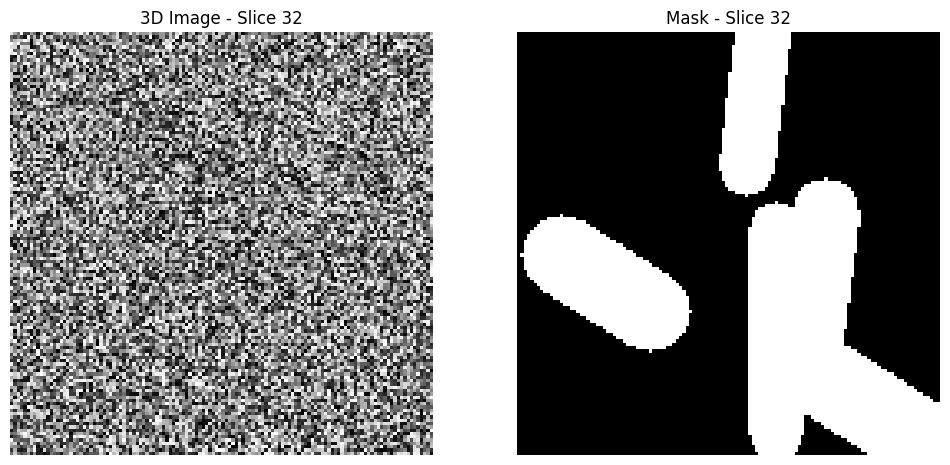

In [3]:
import matplotlib.pyplot as plt
import torch

# Assuming we have the 'image_np' as the 3D numpy array and 'mask' as the generated 3D mask

def plot_3d_slices(image, mask, slice_no):
    """ Plot the given slice number for both image and mask. """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the image slice
    ax[0].imshow(image[slice_no], cmap='gray')
    ax[0].set_title(f'3D Image - Slice {slice_no}')
    ax[0].axis('off')
    
    # Plot the mask slice
    ax[1].imshow(mask[slice_no], cmap='gray')
    ax[1].set_title(f'Mask - Slice {slice_no}')
    ax[1].axis('off')

    plt.show()

# Generate a random 3D image for demonstration
image_tensor = torch.rand(64, 128, 128)  # Example shape
image_np = image_tensor.numpy()

# Generate mask
mask = make_random_irregular_mask_3d(image_np.shape)

# Plot a specific slice (for example, the middle slice)
slice_no = image_np.shape[0] // 2
plot_3d_slices(image_np, mask, slice_no)



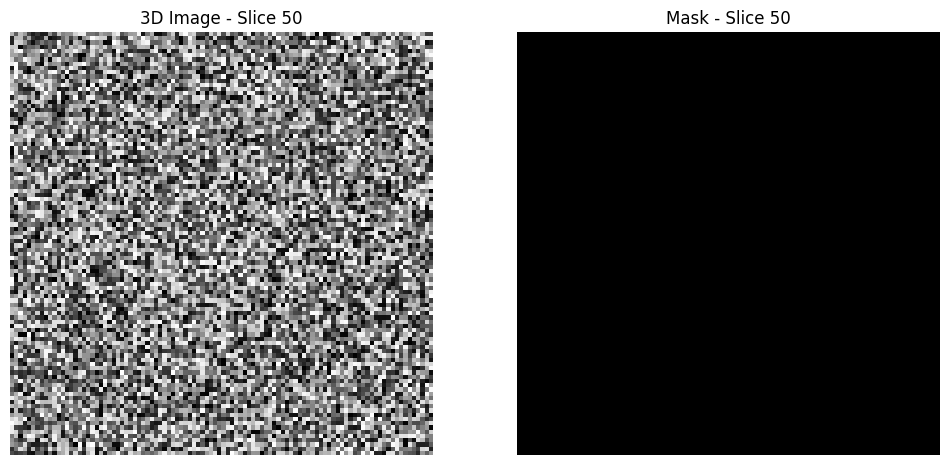

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from enum import Enum

# Enum for draw methods
class DrawMethod(Enum):
    LINE = 'line'
    CIRCLE = 'circle'
    SQUARE = 'square'

def draw_line_3d(volume, start_point, end_point, value=1):
    line = np.zeros_like(volume, dtype=np.float32)
    line_points = list(zip(*line_nd(start_point, end_point)))
    line[line_points] = value
    scipy.ndimage.binary_dilation(line, output=volume, structure=np.ones((3,3,3)), iterations=1, border_value=0)

def line_nd(start, stop, endpoint=True):
    start = np.asarray(start)
    stop = np.asarray(stop)
    npoints = max(np.abs(stop - start)) + 1 if endpoint else max(np.abs(stop - start))
    return np.round(np.linspace(start, stop, num=npoints)).astype(int)

def draw_sphere_3d(volume, center, radius, value=1):
    z, y, x = np.ogrid[-center[0]:volume.shape[0]-center[0], 
                       -center[1]:volume.shape[1]-center[1], 
                       -center[2]:volume.shape[2]-center[2]]
    mask = x**2 + y**2 + z**2 <= radius**2
    volume[mask] = value

def draw_cube_3d(volume, center, size, value=1):
    z_start, z_end = max(center[0] - size // 2, 0), min(center[0] + size // 2, volume.shape[0])
    y_start, y_end = max(center[1] - size // 2, 0), min(center[1] + size // 2, volume.shape[1])
    x_start, x_end = max(center[2] - size // 2, 0), min(center[2] + size // 2, volume.shape[2])
    volume[z_start:z_end, y_start:y_end, x_start:x_end] = value

def make_random_irregular_mask_3d(shape, max_len=60, max_radius=100, min_times=1, max_times=10, draw_method=DrawMethod.LINE):
    depth, height, width = shape
    mask = np.zeros((depth, height, width), np.float32)

    for _ in range(np.random.randint(min_times, max_times + 1)):
        for _ in range(np.random.randint(1, 5)):  # Random shapes per slice
            center = (np.random.randint(depth), np.random.randint(height), np.random.randint(width))
            if draw_method == DrawMethod.LINE:
                end_point = (np.clip(center[0] + np.random.randint(-max_len, max_len), 0, depth-1),
                             np.clip(center[1] + np.random.randint(-max_len, max_len), 0, height-1),
                             np.clip(center[2] + np.random.randint(-max_len, max_len), 0, width-1))
                draw_line_3d(mask, center, end_point, value=1)
            elif draw_method == DrawMethod.CIRCLE:
                radius = np.random.randint(1, max_radius)
                draw_sphere_3d(mask, center, radius, value=1)
            elif draw_method == DrawMethod.SQUARE:
                size = np.random.randint(1, max_radius)
                draw_cube_3d(mask, center, size, value=1)

    return mask

# Generate a random 3D image for demonstration
image = np.random.rand(100, 100, 100)

# Generate a random 3D mask
mask = make_random_irregular_mask_3d(image.shape, draw_method=DrawMethod.LINE)  # Example with CIRCLE method

# Plot a specific slice (for example, the middle slice)
slice_no = image.shape[0] // 2
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image[slice_no], cmap='gray')
ax[0].set_title('3D Image - Slice {}'.format(slice_no))
ax[0].axis('off')
ax[1].imshow(mask[slice_no], cmap='gray')
ax[1].set_title('Mask - Slice {}'.format(slice_no))
ax[1].axis('off')
plt.show()
